In [1]:
# dpo_idefics2-8b.py
from datasets import features, load_dataset
from transformers import AutoModelForVision2Seq, AutoProcessor, LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from trl import DPOConfig, DPOTrainer
from peft import LoraConfig

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/mount/projekte50/projekte/semrel/Models/Abstractness-Concreteness/Tarun_q/venv/dpoenv/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mount/projekte50/projekte/semrel/Models/Abstractness-Concreteness/Tarun_q/venv/dpoenv/lib64/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
No ROCm runtime is found, using ROCM_HOME='/usr'


In [2]:
# Load the model and processor
model_id = "llava-hf/llava-1.5-7b-hf"
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    # cache_dir="./cache",
    load_in_4bit=True,
)
processor = AutoProcessor.from_pretrained(
    model_id, do_image_splitting=False, 
    # cache_dir="./cache"
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
model_id = "llava-hf/llava-v1.6-mistral-7b-hf"

model = LlavaNextForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True,
    load_in_4bit=True,
)
processor = LlavaNextProcessor.from_pretrained(model_id)


# model = torch.compile(model)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


oading checkpoint shards: 100%|██████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.07s/it]

In [4]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 264235008


In [5]:
tokenizer = processor.tokenizer

# Set Chat Template for LLaVA
# processor.chat_template = """{% for message in messages %}{% if message['role'] == 'user' %}USER: {% else %}ASSISTANT: {% endif %}{% for item in message['content'] %}{% if item['type'] == 'text' %}{{ item['text'] }}{% elif item['type'] == 'image' %}<image>{% endif %}{% endfor %}{% if message['role'] == 'user' %} {% else %}{{eos_token}}{% endif %}{% endfor %}"""

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

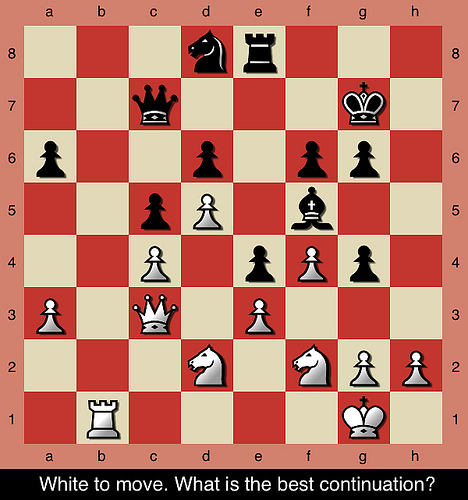

In [6]:
from PIL import Image
image = Image.open("./annotated_images/0ab2de6e9d9a397b4c853f26672d11.jpg").convert("RGB")
display(image)
# # Process the image
# image_output = processor(images=image, return_tensors="pt")

# # Print output structure
# print(image_output)

In [7]:
# Load the dataset
dataset = load_dataset(
    "openbmb/RLAIF-V-Dataset", split="train[:75]", cache_dir="cache"
)

dataset[0]

Using the latest cached version of the dataset since openbmb/RLAIF-V-Dataset couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at cache/openbmb___rlaif-v-dataset/default/0.0.0/586aff0ea91b485a73fe99f65570f054c10c79d9 (last modified on Wed Jan 29 20:50:59 2025).


{'ds_name': 'RLAIF-V',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'question': 'Who is more likely to use these tools a leather crafter or a paper crafter?',
 'chosen': 'A leather crafter is more likely to use these tools. The image shows various crafting tools, including scissors and a hole punch, which are commonly used in leatherworking projects. Leather is a material that requires cutting, shaping, and precise hole-punching techniques to create desired designs or patterns. In contrast, paper crafters typically use different types of tools, such as adhesives, decorative papers, or specialized cutting machines like the Silhouette Cameo, for their projects.',
 'rejected': 'A leather crafter is more likely to use these tools as they consist of a hole punch, scissors, and a knife. These items are typically used in crafting projects involving fabric or leather materials for various designs and patterns. Paper crafters may also benefit from some of these to

In [8]:
def format(example):
    # Prepare the input for the chat template
    
    prompt = [
        {
            "role": "user",
            "content": [{"type": "image"}, {"type": "text", "text": example["question"]}],
        },
    ]
    chosen = [
        {
            "role": "assistant",
            "content": [{"type": "text", "text": example["chosen"]}],
        },
    ]
    rejected = [
        {
            "role": "assistant",
            "content": [{"type": "text", "text": example["rejected"]}],
        },
    ]
    # Apply the chat template
    prompt = processor.apply_chat_template(prompt, tokenize=False)
    chosen = processor.apply_chat_template(chosen, tokenize=False)
    rejected = processor.apply_chat_template(rejected, tokenize=False)
    # Resize the image to ensure it fits within the maximum allowable
    # size of the processor to prevent OOM errors.
    # max_size = processor.image_processor.size["longest_edge"]
    # example["image"].thumbnail((max_size, max_size))
    return {"images": [example["image"]], "prompt": prompt, "chosen": chosen, "rejected": rejected}

# Apply the formatting function to the dataset,
# remove columns to end up with only "images", "prompt", "chosen", "rejected" columns
dataset = dataset.map(format, remove_columns=dataset.column_names)

# Make sure that the images are decoded, it prevents from storing bytes.
# More info here https://github.com/huggingface/blog/pull/2148#discussion_r1667400478
f = dataset.features
f["images"] = features.Sequence(features.Image(decode=True))  # to avoid bytes
dataset = dataset.cast(f)

In [9]:
# print(dataset[0]["inputs"].keys(), dataset[0].keys())
print(dataset[0].keys(), type(dataset[0]["images"]))

dict_keys(['chosen', 'rejected', 'images', 'prompt']) <class 'list'>


In [10]:
dataset[0]

{'chosen': ' A leather crafter is more likely to use these tools. The image shows various crafting tools, including scissors and a hole punch, which are commonly used in leatherworking projects. Leather is a material that requires cutting, shaping, and precise hole-punching techniques to create desired designs or patterns. In contrast, paper crafters typically use different types of tools, such as adhesives, decorative papers, or specialized cutting machines like the Silhouette Cameo, for their projects.<\\s> ',
 'rejected': ' A leather crafter is more likely to use these tools as they consist of a hole punch, scissors, and a knife. These items are typically used in crafting projects involving fabric or leather materials for various designs and patterns. Paper crafters may also benefit from some of these tools, but their primary focus would be on paper-related projects, which might require different types of tools such as paper cutters or scrapbooking supplies.<\\s> ',
 'images': [<PIL

In [11]:
print(type(dataset[0]["images"]), type(dataset[0]["images"][0]))


<class 'list'> <class 'PIL.JpegImagePlugin.JpegImageFile'>


In [12]:

# Step 1: Shuffle dataset
# dataset = dataset.shuffle(seed=42)

# Step 2: Define split ratio (90% train, 10% eval)
train_size = int(0.9 * len(dataset))
eval_size = len(dataset) - train_size

# Step 3: Split dataset
train_dataset = dataset.select(range(train_size))
eval_dataset = dataset.select(range(train_size, len(dataset)))

# Check sizes
print(f"Train set size: {len(train_dataset)}")
print(f"Eval set size: {len(eval_dataset)}")


Train set size: 67
Eval set size: 8


In [13]:
from trl import DPOTrainer, DPOConfig
from transformers import TrainingArguments

training_args = DPOConfig(beta=0.1,
   output_dir="./llava-next-dpo-checkpoints",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=5,
    logging_steps=2,
    learning_rate=5e-5,
    bf16=True,  # Use bfloat16 for efficiency
    gradient_checkpointing=True,
    report_to="none",  # Change to "wandb" if using Weights & Biases
    num_train_epochs=1,
    dataset_num_proc=8,  # tokenization will use 32 processes
    dataloader_num_workers=32,  # data loading will use 32 workers
    )




/mount/projekte50/projekte/semrel/Models/Abstractness-Concreteness/Tarun_q/venv/dpoenv/lib64/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
train_dataset[0]

{'chosen': ' A leather crafter is more likely to use these tools. The image shows various crafting tools, including scissors and a hole punch, which are commonly used in leatherworking projects. Leather is a material that requires cutting, shaping, and precise hole-punching techniques to create desired designs or patterns. In contrast, paper crafters typically use different types of tools, such as adhesives, decorative papers, or specialized cutting machines like the Silhouette Cameo, for their projects.<\\s> ',
 'rejected': ' A leather crafter is more likely to use these tools as they consist of a hole punch, scissors, and a knife. These items are typically used in crafting projects involving fabric or leather materials for various designs and patterns. Paper crafters may also benefit from some of these tools, but their primary focus would be on paper-related projects, which might require different types of tools such as paper cutters or scrapbooking supplies.<\\s> ',
 'images': [<PIL

In [15]:
# peft_config=LoraConfig(
#     target_modules="all-linear", r=2),
peft_config_mine = LoraConfig(
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj",  # Attention layers
                    "gate_proj", "down_proj", "up_proj"],  # MLP layers
    # target_modules="all-linear",
    r=2,  # LoRA rank
    lora_alpha=64,  # Scaling factor
    lora_dropout=0.1,  # Dropout for stability
    bias="none",  # No additional bias
)


In [16]:
trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=processor,
    peft_config=peft_config_mine
)


In [17]:
# # peft_config=LoraConfig(
# #     target_modules="all-linear", r=2),
# peft_config_mine = LoraConfig(
#     # target_modules=["q_proj", "v_proj", "k_proj", "o_proj",  # Attention layers
#     #                 "gate_proj", "down_proj", "up_proj"],  # MLP layers
#     target_modules="all-linear",
#     r=2,  # LoRA rank
#     lora_alpha=64,  # Scaling factor
#     lora_dropout=0.1,  # Dropout for stability
#     bias="none",  # No additional bias
# )


In [18]:
# trainer = DPOTrainer(
#     model,
#     ref_model=None,  # not needed when using peft
#     args=training_args,
#     train_dataset=dataset,
#     processing_class=processor,
#     # peft_config=LoraConfig(target_modules="all-linear", r=2),
#     peft_config = peft_config_mine,
# )

In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)


vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight torch.Size([2, 1024])
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.lora_B.default.weight torch.Size([1024, 2])
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.lora_A.default.weight torch.Size([2, 1024])
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.lora_B.default.weight torch.Size([1024, 2])
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.lora_A.default.weight torch.Size([2, 1024])
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.lora_B.default.weight torch.Size([1024, 2])
vision_tower.vision_model.encoder.layers.1.self_attn.k_proj.lora_A.default.weight torch.Size([2, 1024])
vision_tower.vision_model.encoder.layers.1.self_attn.k_proj.lora_B.default.weight torch.Size([1024, 2])
vision_tower.vision_model.encoder.layers.1.self_attn.v_proj.lora_A.default.weight torch.Size([2, 1024])
vision_tower.vision_model.encoder.layers.1.self_attn.v_proj.lora

In [20]:
print(dataset.features)


{'chosen': Value(dtype='string', id=None), 'rejected': Value(dtype='string', id=None), 'images': Sequence(feature=Image(mode=None, decode=True, id=None), length=-1, id=None), 'prompt': Value(dtype='string', id=None)}


In [21]:
# def format(example):
#     inputs = processor(
#         text=example["question"], images=[example["image"]], return_tensors="pt"
#     )
#     return {
#         "pixel_values": inputs["pixel_values"].squeeze(0),
#         "input_ids": inputs["input_ids"].squeeze(0),
#         "attention_mask": inputs["attention_mask"].squeeze(0),
#         "chosen": example["chosen"],
#         "rejected": example["rejected"],
#     }

# dataset = dataset.map(format, remove_columns=dataset.column_names)


In [22]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 5537792


In [23]:
print(trainer.args.logging_steps)
print(trainer.args.logging_dir)


2
./llava-next-dpo-checkpoints/runs/Jan29_20-52-15_grauweihe.ims.uni-stuttgart.de


In [24]:
import logging
from transformers.utils import logging as hf_logging

logging.basicConfig(level=logging.INFO)
hf_logging.set_verbosity_info()
trainer.args.logging_steps = 2


In [25]:
for batch in trainer.get_train_dataloader():
    print("Batch keys:", batch.keys())
    break  # Only print one batch

The following columns in the training set don't have a corresponding argument in `PeftModel.forward` and have been ignored: images, chosen, prompt, pixel_values, rejected. If images, chosen, prompt, pixel_values, rejected are not expected by `PeftModel.forward`,  you can safely ignore this message.


Batch keys: dict_keys(['prompt_input_ids', 'prompt_attention_mask', 'chosen_input_ids', 'chosen_attention_mask', 'rejected_input_ids', 'rejected_attention_mask', 'image_sizes'])


In [26]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PeftModel.forward` and have been ignored: images, chosen, prompt, pixel_values, rejected. If images, chosen, prompt, pixel_values, rejected are not expected by `PeftModel.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 67
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 8
  Number of trainable parameters = 5,537,792
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/mount/projekte50/projekte/semrel/Models/Abstractness-Concreteness/Tarun_q/venv/dpoenv/lib64/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
2,0.894600,0.673727,2.474358,1.996109,0.625000,0.478249,-125.560280,-126.086952,-2.879633,-2.982081
4,1.220300,0.592844,1.874146,1.268265,0.625000,0.605881,-131.562393,-133.365387,-2.899715,-2.998398
6,1.150200,0.591243,1.598964,0.985531,0.625000,0.613433,-134.314209,-136.192734,-2.944987,-3.047202
8,2.061400,0.592518,1.481874,0.884450,0.625000,0.597424,-135.485107,-137.203537,-2.950321,-3.053449


The following columns in the evaluation set don't have a corresponding argument in `PeftModel.forward` and have been ignored: images, chosen, prompt, pixel_values, rejected. If images, chosen, prompt, pixel_values, rejected are not expected by `PeftModel.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 8
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `PeftModel.forward` and have been ignored: images, chosen, prompt, pixel_values, rejected. If images, chosen, prompt, pixel_values, rejected are not expected by `PeftModel.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 8
  Batch size = 8
Saving model checkpoint to ./llava-next-dpo-checkpoints/checkpoint-5
loading configuration file config.json from cache at /tmp/cache/models--llava-hf--llava-v1.6-mistral-7b-hf/snapshots/0f72cba9626dd63c0d534518a0dd6d792dc95b34/config.json
Model config LlavaNex

TrainOutput(global_step=8, training_loss=1.3316165208816528, metrics={'train_runtime': 550.3315, 'train_samples_per_second': 0.122, 'train_steps_per_second': 0.015, 'total_flos': 0.0, 'train_loss': 1.3316165208816528, 'epoch': 0.9411764705882353})

In [30]:
# Load the model and processor
model_id = "llava-next-dpo-checkpoints/checkpoint-8/"
model2 = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    # cache_dir="./cache",
    load_in_4bit=True,
)
processor2 = AutoProcessor.from_pretrained(
    model_id, do_image_splitting=False, 
    # cache_dir="./cache"
)

loading configuration file config.json from cache at /tmp/cache/models--llava-hf--llava-v1.6-mistral-7b-hf/snapshots/0f72cba9626dd63c0d534518a0dd6d792dc95b34/config.json
Model config LlavaNextConfig {
  "_name_or_path": "llava-hf/llava-v1.6-mistral-7b-hf",
  "architectures": [
    "LlavaNextForConditionalGeneration"
  ],
  "ignore_index": -100,
  "image_grid_pinpoints": [
    [
      336,
      672
    ],
    [
      672,
      336
    ],
    [
      672,
      672
    ],
    [
      1008,
      336
    ],
    [
      336,
      1008
    ]
  ],
  "image_seq_length": 576,
  "image_token_index": 32000,
  "model_type": "llava_next",
  "multimodal_projector_bias": true,
  "projector_hidden_act": "gelu",
  "text_config": {
    "_name_or_path": "mistralai/Mistral-7B-Instruct-v0.2",
    "architectures": [
      "MistralForCausalLM"
    ],
    "intermediate_size": 14336,
    "max_position_embeddings": 32768,
    "model_type": "mistral",
    "num_key_value_heads": 8,
    "rms_norm_eps": 1e-05,


In [31]:
import requests
# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What are these?"},
          {"type": "image"},
        ],
    },
]
prompt = processor2.apply_chat_template(conversation, add_generation_prompt=True)

image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"
raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor2(images=raw_image, text=prompt, return_tensors='pt').to(0, torch.bfloat16)

output = model2.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor2.decode(output[0][2:], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


INST]  
What are these? [/INST] These are two cats lying on a pink surface, which appears to be a couch or a cushion. The cat on the left is curled up with its head resting on its paws, while the cat on the right is stretched out with its head on the surface. There is a remote control next to the cat on the left, suggesting that this scene might be taking place in a living room. 


In [36]:

from transformers import AutoProcessor, LlavaForConditionalGeneration

model_id = "llava-hf/llava-v1.6-mistral-7b-hf"
model = LlavaNextForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
).to(0)


processor = LlavaNextProcessor.from_pretrained(model_id)

image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(image_file, stream=True).raw)


conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What are these?"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(image, prompt, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=100, do_sample=False)

print(processor.decode(output[0][2:], skip_special_tokens=True))


loading configuration file config.json from cache at /tmp/cache/models--llava-hf--llava-v1.6-mistral-7b-hf/snapshots/0f72cba9626dd63c0d534518a0dd6d792dc95b34/config.json
Model config LlavaNextConfig {
  "architectures": [
    "LlavaNextForConditionalGeneration"
  ],
  "ignore_index": -100,
  "image_grid_pinpoints": [
    [
      336,
      672
    ],
    [
      672,
      336
    ],
    [
      672,
      672
    ],
    [
      1008,
      336
    ],
    [
      336,
      1008
    ]
  ],
  "image_seq_length": 576,
  "image_token_index": 32000,
  "model_type": "llava_next",
  "multimodal_projector_bias": true,
  "projector_hidden_act": "gelu",
  "text_config": {
    "_name_or_path": "mistralai/Mistral-7B-Instruct-v0.2",
    "architectures": [
      "MistralForCausalLM"
    ],
    "intermediate_size": 14336,
    "max_position_embeddings": 32768,
    "model_type": "mistral",
    "num_key_value_heads": 8,
    "rms_norm_eps": 1e-05,
    "rope_theta": 1000000.0,
    "sliding_window": null,

INST]  
What are these? [/INST] These are two cats lying on a pink blanket. The cat on the left appears to be a kitten with a striped coat, while the cat on the right is a larger cat with a tabby pattern. They seem to be resting or sleeping, and there are remote controls next to them, suggesting they might be in a living room or a similar space where people relax and watch television. 
